In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

module_path = os.path.abspath(os.path.join("../.."))
sys.path.append(module_path)

## Dataset and hyperparameters loading

In [3]:
import torch
from torchvision.transforms.v2 import Compose

from SLTDataset import SLTDataset
from posecraft.Pose import Pose
from helpers import create_src_mask
from hyperparameters import load_hyperparameters_from_json


DATASET = "GSL"
EXPERIMENT_ID = "golden-mountain-46"

dataset_path = f"/mnt/disk3Tb/slt-datasets/{DATASET}"
experiment_path = f"results/{DATASET}/{EXPERIMENT_ID}"
hp = load_hyperparameters_from_json(f"{experiment_path}/hp.json")
output_path = f"{experiment_path}/interp/avg"
os.makedirs(output_path, exist_ok=True)
transparent_plot = False

landmarks_mask = Pose.get_components_mask(hp["LANDMARKS_USED"])
transforms: Compose = Compose(hp["TRANSFORMS"])

test_dataset = SLTDataset(
    data_dir=dataset_path,
    split="test",
    input_mode=hp["INPUT_MODE"],
    output_mode=hp["OUTPUT_MODE"],
    transforms=transforms,
    max_tokens=hp["MAX_TOKENS"],
)

Loaded metadata for dataset: The Greek Sign Language (GSL) Dataset
Loaded test annotations at /mnt/disk3Tb/slt-datasets/GSL/annotations.csv


Validating files: 100%|██████████| 881/881 [00:00<00:00, 249927.75it/s]

Dataset loaded correctly



In [4]:
import pandas as pd

results = pd.read_csv(f"{experiment_path}/translations.csv")
results["length"] = results["y"].apply(lambda x: len(x.split()))
correct = results[results["trans_greedy"] == results["y"]]
correct

,y,trans_greedy,trans_beam,bleu_1_greedy,bleu_2_greedy,bleu_3_greedy,bleu_4_greedy,bleu_1_beam,bleu_2_beam,bleu_3_beam,bleu_4_beam,length
0,ΓΕΙΑ ΕΓΩ(1) ΜΠΟΡΩ ΒΟΗΘΕΙΑ,ΓΕΙΑ ΕΓΩ(1) ΜΠΟΡΩ ΒΟΗΘΕΙΑ,ΓΕΙΑ ΕΓΩ(1) ΜΠΟΡΩ ΒΟΗΘΕΙΑ,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4
1,ΕΓΩ(1) ΘΕΛΩ ΠΑΡΑΠΟΝΟ ΚΑΤΑΓΓΕΛΙΑ,ΕΓΩ(1) ΘΕΛΩ ΠΑΡΑΠΟΝΟ ΚΑΤΑΓΓΕΛΙΑ,ΕΓΩ(1) ΘΕΛΩ ΠΑΡΑΠΟΝΟ ΚΑΤΑΓΓΕΛΙΑ,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4
3,ΩΡΑ ΓΙΑ ΗΣΥΧΙΑ ΑΚΟΥΩ ΦΑΣΑΡΙΑ,ΩΡΑ ΓΙΑ ΗΣΥΧΙΑ ΑΚΟΥΩ ΦΑΣΑΡΙΑ,ΩΡΑ ΓΙΑ ΗΣΥΧΙΑ ΑΚΟΥΩ ΦΑΣΑΡΙΑ,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5
5,ΣΠΙΤΙ ΕΓΩ(1) ΚΑΤΩ(1) ΜΑΓΑΖΙ,ΣΠΙΤΙ ΕΓΩ(1) ΚΑΤΩ(1) ΜΑΓΑΖΙ,ΣΠΙΤΙ ΕΓΩ(1) ΚΑΤΩ(1) ΜΑΓΑΖΙ,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4
6,ΠΡΙΝ ΕΣΥ ΙΔΙΟΚΤΗΤΗΣ ΕΣΥ_ΣΥΖΗΤΑΩ_ΑΥΤΟΝ,ΠΡΙΝ ΕΣΥ ΙΔΙΟΚΤΗΤΗΣ ΕΣΥ_ΣΥΖΗΤΑΩ_ΑΥΤΟΝ,ΠΡΙΝ ΕΣΥ ΙΔΙΟΚΤΗΤΗΣ ΕΣΥ_ΣΥΖΗΤΑΩ_ΑΥΤΟΝ,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
875,ΕΝΤΑΞΕΙ,ΕΝΤΑΞΕΙ,ΕΝΤΑΞΕΙ,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
876,ΕΓΩ(1) ΕΝΗΜΕΡΩΝΩ_ΕΣΕΝΑ ΤΡΟΠΟΣ ΤΑΧΥΔΡΟΜΕΙΟ,ΕΓΩ(1) ΕΝΗΜΕΡΩΝΩ_ΕΣΕΝΑ ΤΡΟΠΟΣ ΤΑΧΥΔΡΟΜΕΙΟ,ΕΓΩ(1) ΕΝΗΜΕΡΩΝΩ_ΕΣΕΝΑ ΤΡΟΠΟΣ ΤΑΧΥΔΡΟΜΕΙΟ,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4
877,ΕΥΧΑΡΙΣΤΩ,ΕΥΧΑΡΙΣΤΩ,ΕΥΧΑΡΙΣΤΩ,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
878,ΓΡΑΜΜΑΤΕΙΑ ΜΕΤΑ ΧΑΡΤΙ ΕΓΚΡΙΣΗ ΑΥΤΗ_ΔΙΝΩ_ΕΣΕΝΑ,ΓΡΑΜΜΑΤΕΙΑ ΜΕΤΑ ΧΑΡΤΙ ΕΓΚΡΙΣΗ ΑΥΤΗ_ΔΙΝΩ_ΕΣΕΝΑ,ΓΡΑΜΜΑΤΕΙΑ ΜΕΤΑ ΧΑΡΤΙ ΕΓΚΡΙΣΗ ΑΥΤΗ_ΔΙΝΩ_ΕΣΕΝΑ,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5


In [5]:
len(correct)

714

In [83]:
lenghts = sorted(list(correct["length"].unique() + 1))
print(lenghts)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 19]


# Interpretability

In [6]:
from torch import Tensor
import pickle


# each dict contains for each sample, a dict that contains for each layer, a list of attention weights per call (one for the encoder, one per word for the decoder)
encoder_sa: dict[int, dict[int, list[Tensor]]] = pickle.load(
    open(f"{experiment_path}/interp/encoder_sa.pkl", "rb")
)
decoder_sa: dict[int, dict[int, list[Tensor]]] = pickle.load(
    open(f"{experiment_path}/interp/decoder_sa.pkl", "rb")
)
decoder_ca: dict[int, dict[int, list[Tensor]]] = pickle.load(
    open(f"{experiment_path}/interp/decoder_ca.pkl", "rb")
)
intermediate_outputs: dict[int, dict[str, list[Tensor]]] = pickle.load(
    open(f"{experiment_path}/interp/intermediate_outputs.pkl", "rb")
)

## Decoder CA average

Get the interpolated version of the attention weights to 100 frames

In [7]:
from torch.nn.functional import interpolate


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

interpolated_decoder_ca: dict[int, dict[int, list[Tensor]]] = {}
for sample_id, sample in decoder_ca.items():
    interpolated_decoder_ca[sample_id] = {}
    for layer, cas in sample.items():
        src, tgt = test_dataset[sample_id]
        src_mask, src_padding_mask = create_src_mask(src.to(device), device)
        attn_weights = [
            torch.stack([c.to(device)[:, ~src_padding_mask] for c in t]) for t in cas
        ]
        interpolated_decoder_ca[sample_id][layer] = [
            interpolate(aw, size=(100), mode="linear").squeeze(0) for aw in attn_weights
        ]

In [8]:
from interp.plot_functions import preprocess_attn_weights

LAYER = 0
processed_decoder_ca = [
    preprocess_attn_weights([s.unsqueeze(0) for s in sample[LAYER]])
    for sample_id, sample in interpolated_decoder_ca.items()
    if sample_id in correct.index
]

In [77]:
token_length = 4
processed_decoder_ca_per_length = [
    p for p in processed_decoder_ca if p.shape[0] == token_length
]

mean_decoder_ca = torch.stack(processed_decoder_ca_per_length).mean(dim=0)

<Axes: >

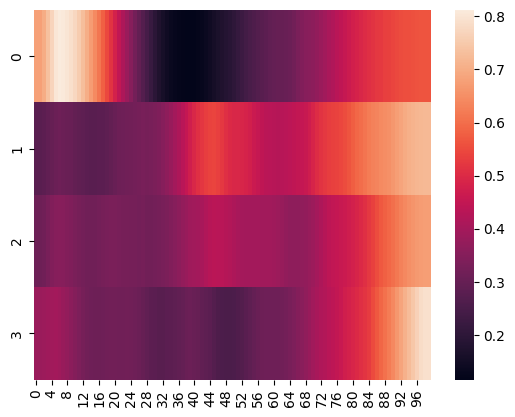

In [78]:
import seaborn as sns

sns.heatmap(mean_decoder_ca.cpu())

## Intermediate outputs

In [64]:
def reorganize_list(input_list, N):
    grouped_list = []
    for i in range(N):
        grouped_list.extend(input_list[i::N])
    return grouped_list


attn_diffs: list[Tensor] = []
for sample in intermediate_outputs:
    src, tgt = test_dataset[sample]
    translation = [t for t in tgt if t != test_dataset.tokenizer.pad_token_id]
    diff_sa_mha_block = [
        t1 - t2
        for t1, t2 in zip(
            intermediate_outputs[sample]["sa_block"],
            intermediate_outputs[sample]["mha_block"],
        )
    ]
    attn_diffs.append(
        torch.Tensor(
            [float(diff_sa_mha_block[i].mean()) for i in range(len(diff_sa_mha_block))]
        )
    )

In [86]:
for l in lenghts:
    attn_diffs_per_length = [
        p for i, p in enumerate(attn_diffs) if len(p) == l and i in correct.index
    ]
    mean = torch.stack(attn_diffs_per_length).mean(dim=0)
    print(f"Length {l}: {mean}")

Length 2: tensor([-0.1734, -0.1162])
Length 3: tensor([-0.0479,  0.0373,  0.0763])
Length 4: tensor([-0.0859, -0.0041,  0.0514,  0.0810])
Length 5: tensor([-0.0752, -0.0112,  0.0282,  0.0590,  0.0943])
Length 6: tensor([-0.1038, -0.0578, -0.0100,  0.0183,  0.0613,  0.0779])
Length 7: tensor([-0.0696, -0.0190,  0.0254,  0.0341,  0.0429,  0.0440,  0.0489])
Length 8: tensor([-0.0665, -0.0220,  0.0290,  0.0242,  0.0261,  0.0131,  0.0173,  0.0333])
Length 9: tensor([-0.1174, -0.0222,  0.0501,  0.0548,  0.0540,  0.0794,  0.0983,  0.0832,
         0.0940])
Length 10: tensor([-0.0100, -0.0071,  0.0082,  0.0455,  0.0857,  0.1039,  0.1109,  0.1060,
         0.0935,  0.0874])
Length 11: tensor([-0.1099, -0.0153,  0.0184,  0.0070, -0.0009, -0.0010,  0.0013,  0.0162,
         0.0120,  0.0133,  0.0220])
Length 12: tensor([-0.1136, -0.0874, -0.0569, -0.0268, -0.0623, -0.0292,  0.0372,  0.0074,
         0.0011, -0.0186, -0.0015,  0.0623])
Length 19: tensor([-0.2936, -0.1894, -0.2159, -0.1707, -0.0904,

## Encoder SA average